In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba
import warnings
warnings.filterwarnings('ignore')

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')
sys.path.append('../')

# Configure matplotlib for publication quality
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif', 'serif'],
    'text.usetex': False,  # Set to True if LaTeX is available
    'figure.figsize': [10, 8],
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
    'axes.linewidth': 1.2,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

# Check which font is actually being used
import matplotlib.font_manager as fm
font_prop = fm.FontProperties(family='serif')
print(f"Active serif font: {font_prop.get_name()}")
print(f"Available serif fonts: {[f.name for f in fm.fontManager.ttflist if 'serif' in f.name.lower()][:5]}")  # Show first 5

# Import SpyDust modules
import functools
import SpyDust.Grain as Grain
from SpyDust.SpyDust import SpyDust_given_grain_size_shape
from SpyDust.util import makelogtab, cgsconst
from SpyDust.SPDUST_as_is import emissivity
import matplotlib.cm as cm

from SpyDust.SED_fit import fit_sed_ensemble
# from mcpost import gsa_pipeline


Active serif font: Times New Roman
Available serif fonts: ['DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'DejaVu Serif']
l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
Gaunt factor stored
l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Maximum energy in the Qabs_hnu_tab is 1239.84 eV.
FIR_integral_charged shape: (30, 30)
Na: 30, Nchi: 30
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
Gaunt factor stored


In [2]:
four_params_arr = np.loadtxt("data/MC_emu/MC_dist_params_4.txt")
four_params_log_moments = np.loadtxt('data/MC_emu/MC_SED_logmoments_4.txt')
four_params_features = np.loadtxt('data/MC_emu/MC_SED_feature_4.txt')
four_params_dist_moments = np.loadtxt('data/MC_emu/MC_dist_Mom_4.txt')

two_params_arr = np.loadtxt("data/MC_emu/MC_dist_params.txt")
two_params_log_moments = np.loadtxt('data/MC_emu/MC_SED_logmoments.txt')
two_params_features = np.loadtxt('data/MC_emu/MC_SED_feature.txt')
# two_params_dist_moments = np.loadtxt('data/MC_emu/MC_dist_Mom.txt')


peak_lognu = four_params_features[:, 0]
width = four_params_features[:, 1]
skewness = four_params_log_moments[:, 2]
excess_kurtosis = four_params_log_moments[:, 3]

assemble_features = np.vstack([peak_lognu, width, skewness, excess_kurtosis]).T


In [61]:
# # Create the mapping emulator from the features to the distribution moments
# from MomentEmu import PolyEmu

# MC_feature_emu_2p = PolyEmu(
#     two_params_arr,
#     two_params_features,
#     forward=True,             
#     max_degree_forward=20,  
#     backward=True,
#     max_degree_backward=20,   
#     return_max_frac_err=True
# )


In [ ]:
# Create the mapping emulator from the features to the distribution moments
from MomentEmu import PolyEmu

# generate the mask where skewness and kurtosis are within [-0.2, 0.2]
threshold_skew = 1.0
threshold_exe_kurt = 1.0

mask = (np.abs(skewness) <= threshold_skew) & (np.abs(excess_kurtosis) <= threshold_exe_kurt)

print(f"Number of samples used for emulator training: {np.sum(mask)} out of {len(assemble_features)}")

MC_log_SED = PolyEmu(      
    # four_params_arr[mask], 
    four_params_dist_moments[mask],
    assemble_features[mask],
    forward=True,             
    max_degree_forward=20,  
    backward=True,
    max_degree_backward=20,   
    return_max_frac_err=True
)



Number of samples used for emulator training: 19768 out of 20000

 Generating forward emulator...
Maximum degree 20 reached. Now choose the best fit. 
Candidate models within 10.0% of min RMSE : [5]
RMSE of candidate models : [0.04424635]
Selected best model index based on BIC : 5
Forward emulator generated with degree 7, RMSE_val of 0.04424634679479019.
Performing dimension reduction...
Dimension reduced  from 330 modes to 330 modes.
After the dimension reduction, the RMSE: 0.04424634679479019, AIC: -17835.87200756816, BIC: -101566.02933859242

Forward emulator maximum fractional error: 301.1067813655152 at index (np.int64(2658), np.int64(3)). 
                       True value: -7.977247207469063e-05, Predicted value: 0.02394028994658398 
                       (If the true value is close to 0, this value could be very large.)
Generating backward emulator...


Candidate models within 10.0% of min RMSE : [4 6]
RMSE of candidate models : [0.07700708 0.08433882]
Selected best model index based on BIC : 4
Backward emulator generated with degree 6, RMSE_val of 0.07700708090668368.
Performing dimension reduction...
Dimension reduced  from 210 modes to 210  modes.
After the dimension reduction, the RMSE: 0.07700708090668368, AIC: -14788.805071872628, BIC: -84112.73774975105

Backward emulator maximum fractional error: 89.89127767089573 at index (np.int64(2370), np.int64(3)). 
                       True value: 3.3353529884681822e-12, Predicted value: -9.285611555717951e-09 
                       (If the true value is close to 0, this value could be very large.)


In [8]:
np.median(skewness)

np.float64(-0.4573586572114981)

In [22]:
# Load the catalogues
MC_catalogue = np.loadtxt("data/MC_catalogue.txt")

aux_MC_catalogue = np.zeros((MC_catalogue.shape[0], 4))
aux_MC_catalogue[:, 0] = np.log(MC_catalogue[:, 0])  # log peak freq
aux_MC_catalogue[:, 1] = MC_catalogue[:, 1]  # width
# The observation catalogue does not have skewness and kurtosis values, we leave them as median values of the training set
aux_MC_catalogue[:, 2] =  np.ones_like(MC_catalogue[:, 0]) * (-0.2)
# aux_MC_catalogue[:, 3] = np.ones_like(MC_catalogue[:, 0]) * np.median(excess_kurtosis) 

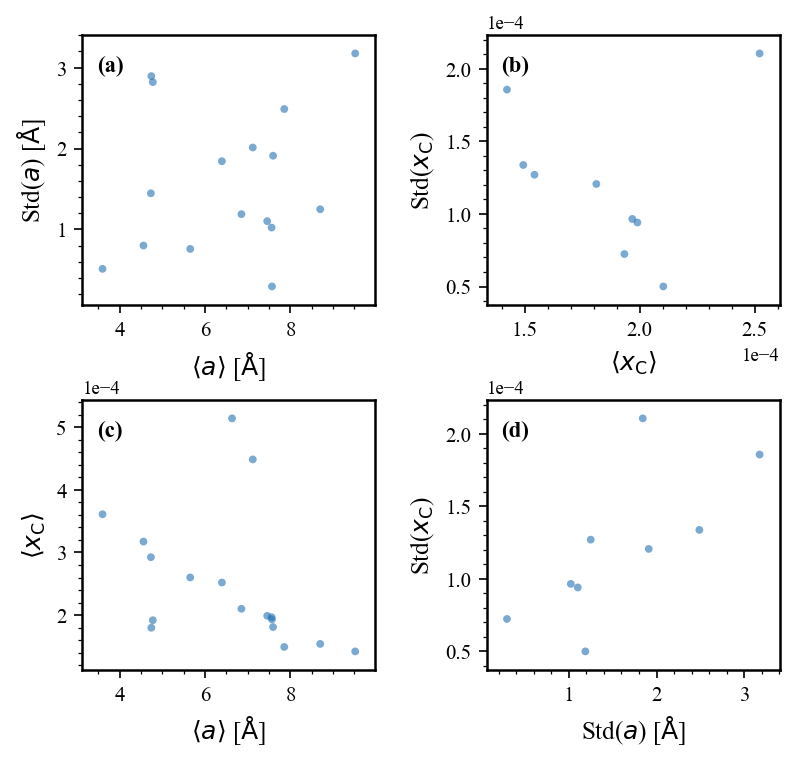

In [24]:
# ...existing code...
inferred_dist_moments = MC_log_SED.backward_emulator(aux_MC_catalogue)
a_mean = inferred_dist_moments[:, 0]
a_std_dev = np.sqrt(inferred_dist_moments[:, 1])
xC_mean = inferred_dist_moments[:, 2]
xC_std_dev = np.sqrt(inferred_dist_moments[:, 3])

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde

fig = plt.figure(figsize=(6,5.5))
gs = GridSpec(2, 2, figure=fig, wspace=0.38, hspace=0.35)

# Helper function for scatter plot with positive axis handling
def density_scatter(ax, x, y, xlabel, ylabel, color='#2171b5'):
    """Create a scatter plot with proper axis limits for positive values."""
    # Remove NaN/Inf values and filter for positive values
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    x_clean, y_clean = x[mask], y[mask]
    
    sc = ax.scatter(x_clean, y_clean, s=14, c=color, alpha=0.6, 
                    edgecolors='none', rasterized=True)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Set axis limits to positive range with padding
    x_min, x_max = x_clean.min(), x_clean.max()
    x_pad = 0.08 * (x_max - x_min)
    ax.set_xlim(max(0, x_min - x_pad), x_max + x_pad)
    
    y_min, y_max = y_clean.min(), y_clean.max()
    y_pad = 0.08 * (y_max - y_min)
    ax.set_ylim(max(0, y_min - y_pad), y_max + y_pad)
    
    # Add minor ticks
    ax.minorticks_on()
    ax.tick_params(which='minor', length=2, width=0.6)
    ax.tick_params(which='major', length=4, width=0.8)
    
    return len(x_clean)

# Panel (a): Grain size mean vs std dev
ax1 = fig.add_subplot(gs[0, 0])
n1 = density_scatter(ax1, a_mean, a_std_dev,
                     r'$\langle a \rangle$ [$\mathrm{\AA}$]',
                     r'Std(${a}$) [$\mathrm{\AA}$]')
ax1.text(0.05, 0.92, r'(a)', transform=ax1.transAxes, fontsize=11, fontweight='bold', va='top')

# Panel (b): Carbon fraction mean vs std dev
ax2 = fig.add_subplot(gs[0, 1])
n2 = density_scatter(ax2, xC_mean, xC_std_dev,
                     r'$\langle x_{\rm C} \rangle$',
                     r'Std(${x_{\rm C}}$)')
ax2.text(0.05, 0.92, r'(b)', transform=ax2.transAxes, fontsize=11, fontweight='bold', va='top')
ax2.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))
ax2.xaxis.get_offset_text().set_fontsize(9)
ax2.yaxis.get_offset_text().set_fontsize(9)

# Panel (c): a_mean vs xC_mean correlation
ax3 = fig.add_subplot(gs[1, 0])
n3 = density_scatter(ax3, a_mean, xC_mean,
                     r'$\langle a \rangle$ [$\mathrm{\AA}$]',
                     r'$\langle x_{\rm C} \rangle$')
ax3.text(0.05, 0.92, r'(c)', transform=ax3.transAxes, fontsize=11, fontweight='bold', va='top')
ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax3.yaxis.get_offset_text().set_fontsize(9)

# Panel (d): a_std_dev vs xC_std_dev correlation
ax4 = fig.add_subplot(gs[1, 1])
n4 = density_scatter(ax4, a_std_dev, xC_std_dev,
                     r'Std(${a}$) [$\mathrm{\AA}$]',
                     r'Std(${x_{\rm C}}$)')
ax4.text(0.05, 0.92, r'(d)', transform=ax4.transAxes, fontsize=11, fontweight='bold', va='top')
ax4.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax4.yaxis.get_offset_text().set_fontsize(9)

# # Add sample count annotation
# fig.text(0.99, 0.01, f'$N = {n1}$', fontsize=9, style='italic', 
#          color='0.5', ha='right', va='bottom')

plt.savefig("inferred_distribution_moments.pdf", bbox_inches="tight", dpi=300)
plt.show()